### Импорт всех необходимых библиотек

In [11]:
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.optim import Adam
from torchvision import transforms
from torchvision.models import vgg16
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm
import numpy as np
from sklearn.metrics import classification_report
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image

### Инициализация претренированной сети vgg 16 и изменение последнего слоя

In [12]:
model = vgg16(pretrained=True, progress=False)

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
for param in model.parameters():
    param.requires_grad = False

model.classifier[6] = torch.nn.Linear(4096, 3)
model = model.to(device)

### Ресайз, нормализация и аугументация

In [14]:
my_transform_train = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(32),
        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                             std=(0.229, 0.224, 0.225)),
        transforms.RandomRotation((-10, 10)),
        transforms.RandomHorizontalFlip(p=0.5)
    ]
)
my_transform_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(64),
        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                             std=(0.229, 0.224, 0.225))
    ]
)

### Чтение файлов в датасет и применения трансформаций

In [15]:
train_dataset = ImageFolder(root='data/train', transform=my_transform_train)
test_dataset = ImageFolder(root='data/val', transform=my_transform_test)

### Объявление даталоадеров

In [16]:
batch_size = 256
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [17]:
num_epochs = 16
lr = 1e-5
optimizer = Adam(model.parameters(), lr=lr)

In [90]:
### Используем скедулер для уменьшения лернинг рейта
scheduler = ReduceLROnPlateau(optimizer=optimizer, factor=0.5, patience=2, threshold=1e-3)

### Объявление loss функции

In [19]:

def loss_function(preds, true):
    loss = nn.CrossEntropyLoss()
    return loss(preds, true)

In [ ]:
all_train_losses = []
all_test_losses = []

### Обучение и визуализация процесса обучения

loss train 0.7134087545829908
loss test 0.19479677677154542


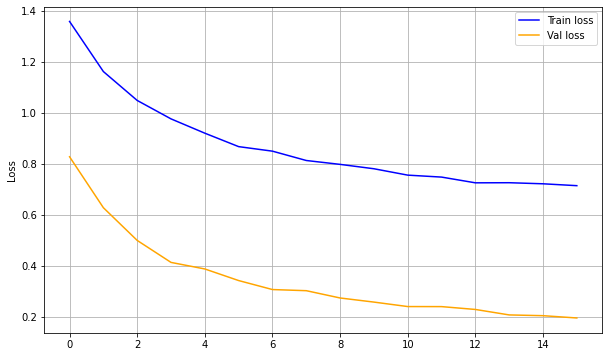

In [26]:
for epoch in range(num_epochs):
    train_loss = 0
    test_loss = 0
    model.train(True)
    print(f'epoch_number is {epoch}. Train')
    for (X, y) in tqdm(train_dataloader):
        model.zero_grad()
        X = X.to(device)
        y = y.to(device)
        preds = model.forward(X)
        loss = loss_function(preds, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.detach().item()/(len(train_dataloader))
    model.train(False)
    model.eval()
    print(f'epoch_number is {epoch}. Test')
    for (X, y) in tqdm(test_dataloader):
        X = X.to(device)
        y = y.to(device)
        preds = model.forward(X)
        loss = loss_function(preds, y)
        test_loss += loss.detach().item()/(len(test_dataloader))
    scheduler.step(test_loss)
    clear_output()
    all_train_losses.append(train_loss)
    all_test_losses.append(test_loss)
    print('loss train', train_loss)
    print('loss test', test_loss)
    plt.figure(figsize = (10, 6))
    plt.plot(all_train_losses, label = 'Train loss', color = 'blue')
    plt.plot(all_test_losses, label = 'Val loss', color = 'orange')
    plt.legend()
    plt.ylabel('Loss')
    plt.grid()
    plt.show()

### Вывод метрик модели

In [27]:
final_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

In [28]:
preds = []
real = []
for x, y in final_dataloader:
    preds.append(model.forward(x.to(device)).detach().cpu().numpy())
    real.append(y.numpy())

In [29]:
final_preds = np.concatenate(preds).argmax(axis=1)
real = np.concatenate(real)

In [30]:
print(classification_report(real, final_preds))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91       500
           1       0.95      0.95      0.95       500
           2       0.89      0.93      0.91       500

    accuracy                           0.92      1500
   macro avg       0.92      0.92      0.92      1500
weighted avg       0.92      0.92      0.92      1500



### Сохранение модели

In [31]:
torch.save(model.state_dict(), 'model.pth')

### Предсказание на тесте ( вообще функция подойдет для любой картинки, до нее нужно лишь указать путь)

In [65]:
dict_names = {
    0: 'Кошка',
    1: 'Собака',
    2: 'Дикая'
}

In [77]:
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [84]:
def predict_by_path(path):
    image = Image.open(path)
    image_np =  np.array(image)
    pred = model.forward(my_transform_train(image_np).to(device).unsqueeze(0)).cpu().detach().numpy()[0]
    plt.imshow(image)
    res = np.argmax(pred)
    print(dict_names[res])

Кошка


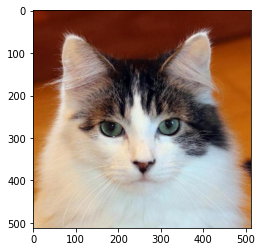

In [85]:
predict_by_path('data/val/cat/flickr_cat_000008.jpg')

Собака


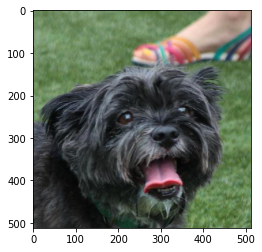

In [86]:
predict_by_path('data/val/dog/flickr_dog_000060.jpg')

Дикая


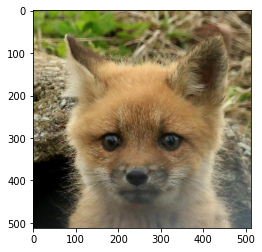

In [89]:
predict_by_path('data/val/wild/flickr_wild_000012.jpg')